# Importing Libraries

In [77]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score
import time
import pickle 
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading Files

In [78]:
crude_oil_prices = pd.read_csv('../InputData/crude_oil_prices.csv')
federal_rates = pd.read_csv('../InputData/effective_federal_funds_rate.csv')
corridor_rates = pd.read_csv('../InputData/egyptian_corridor_interest_rates.csv')
housing_index = pd.read_csv('../InputData/housing_index.csv')
inflation_mom = pd.read_csv('../InputData/inflation_month_on_month.csv')
inflation_yoy = pd.read_csv('../InputData/inflation_year_on_year.csv')
news_data = pd.read_csv('../InputData/news.csv')
stock_prices = pd.read_csv('../InputData/stocks_prices_and_volumes.csv')
vix_indices = pd.read_csv('../InputData/vix_index.csv')
vixeem_indices = pd.read_csv('../InputData/vxeem_index.csv')
gold_prices = pd.read_csv('../InputData/intraday_gold.csv')
gold_prices_target = pd.read_csv('../InputData/target_gold.csv')

In [79]:
gold_prices_target.head()

,date,pct_change
0,2020-01-01,0.129032
1,2020-01-02,1.288660
2,2020-01-03,0.636132
3,2020-01-04,0.126422
4,2020-01-05,1.262626


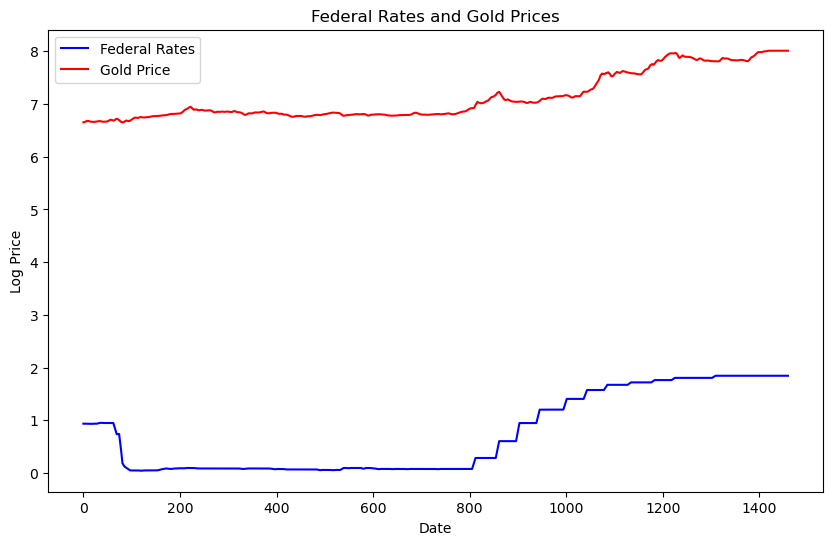

In [80]:
merged_data_list_federal_gold = []

# Convert 'Date' columns to date object
federal_rates['Date'] = pd.to_datetime(federal_rates['Date']).dt.date
gold_prices['Timestamp'] = pd.to_datetime(gold_prices['Timestamp'], errors='coerce', utc=True)
gold_prices['Date'] = gold_prices['Timestamp'].dt.date

# Get daily gold prices
gold_daily = gold_prices.groupby('Date').last().reset_index()

for federal_rates_column in federal_rates.columns:
    if federal_rates_column == 'Date':
        continue

    # Get start and end dates relative to each dataset
    start_date = max(federal_rates['Date'].min(), gold_daily['Date'].min())
    end_date = min(federal_rates['Date'].max(), gold_daily['Date'].max())

    # Filter the data based on start and end date
    federal_rates_filtered = federal_rates[(federal_rates['Date'] >= start_date) & (federal_rates['Date'] <= end_date)]
    gold_daily_filtered = gold_daily[(gold_daily['Date'] >= start_date) & (gold_daily['Date'] <= end_date)]

    # Merge the two datasets on 'Date'
    merged_data = pd.merge(federal_rates_filtered, gold_daily_filtered, on='Date', how='inner')

    # Ensure the columns are numeric
    merged_data[federal_rates_column] = pd.to_numeric(merged_data[federal_rates_column], errors='coerce')
    merged_data['24K'] = pd.to_numeric(merged_data['24K'], errors='coerce')

    # Apply interpolation only to numeric columns
    numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
    merged_data[numeric_cols] = merged_data[numeric_cols].interpolate(method='linear', limit_direction='both')

    # Create Log Columns
    merged_data['log_federal_rates'] = np.log(merged_data[federal_rates_column] + 1)
    merged_data['Log_Gold_Price'] = np.log(merged_data['24K'] + 1)

    # Calculate the mean and standard deviation for both series
    mean_gold_price = merged_data['Log_Gold_Price'].mean()
    std_gold_price = merged_data['Log_Gold_Price'].std()
    mean_stock_price = merged_data['log_federal_rates'].mean()
    std_stock_price = merged_data['log_federal_rates'].std()

    # Calculate thresholds for outliers
    threshold_upper_gold = mean_gold_price + 2 * std_gold_price
    threshold_lower_gold = mean_gold_price - 2 * std_gold_price
    threshold_upper_stock = mean_stock_price + 2 * std_stock_price
    threshold_lower_stock = mean_stock_price - 2 * std_stock_price

    # Remove duplicate dates
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    merged_data = merged_data.drop_duplicates(subset='Date')

    # Mask outliers
    outlier_mask_gold = (merged_data['Log_Gold_Price'] < threshold_lower_gold) | (merged_data['Log_Gold_Price'] > threshold_upper_gold)
    outlier_mask_stock = (merged_data['log_federal_rates'] < threshold_lower_stock) | (merged_data['log_federal_rates'] > threshold_upper_stock)

    # Set outliers to NaN
    merged_data.loc[outlier_mask_gold, 'Log_Gold_Price'] = np.nan
    merged_data.loc[outlier_mask_stock, 'log_federal_rates'] = np.nan

    # Interpolate missing values for log columns
    merged_data['Log_Gold_Price'] = merged_data['Log_Gold_Price'].interpolate(method='linear')
    merged_data['log_federal_rates'] = merged_data['log_federal_rates'].interpolate(method='linear')

    # Apply rolling mean for smoothing
    merged_data['smoothed_log_federal_rates'] = merged_data['log_federal_rates'].rolling(window=7, min_periods=1).mean()
    merged_data['Smoothed_Log_Gold_Price'] = merged_data['Log_Gold_Price'].rolling(window=7, min_periods=1).mean()

    # Filter necessary columns and reindex using the date range
    filtered_data = merged_data[['Date', 'smoothed_log_federal_rates', 'Smoothed_Log_Gold_Price']]
    filtered_data = filtered_data.set_index('Date').reindex(date_range).reset_index()

    # Apply interpolation only to numeric columns after reindexing
    numeric_filtered_cols = filtered_data.select_dtypes(include=['float64', 'int64']).columns
    filtered_data[numeric_filtered_cols] = filtered_data[numeric_filtered_cols].interpolate(method='linear')

    # No dropping rows, keeping NaNs as is

    merged_data_list_federal_gold.append(filtered_data)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['smoothed_log_federal_rates'], label='Federal Rates', color='blue')
    plt.plot(filtered_data['Smoothed_Log_Gold_Price'], label='Gold Price', color='red')
    plt.title('Federal Rates and Gold Prices')
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.legend()
    plt.show()


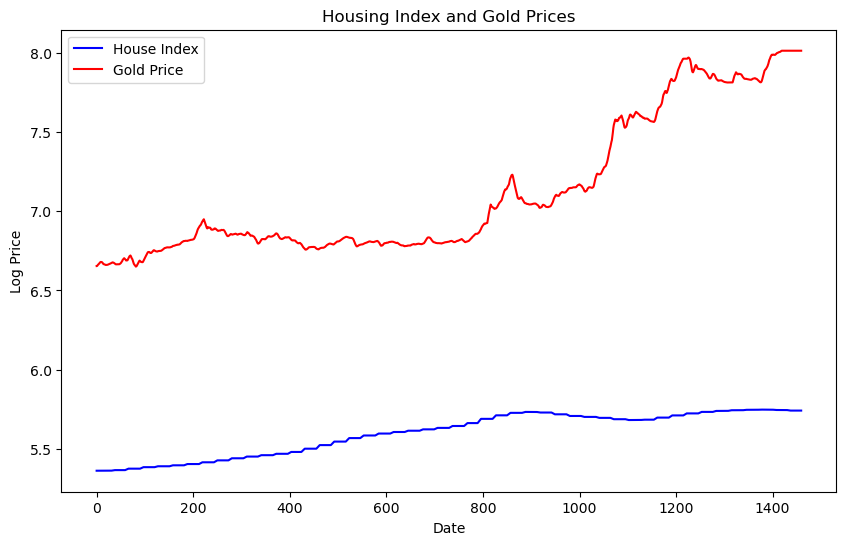

In [81]:
merged_data_list_house_gold = []

# Convert 'Date' columns to date object
housing_index['Date'] = pd.to_datetime(housing_index['Date']).dt.date
gold_prices['Timestamp'] = pd.to_datetime(gold_prices['Timestamp'], errors='coerce', utc=True)
gold_prices['Date'] = gold_prices['Timestamp'].dt.date

# Get daily gold prices
gold_daily = gold_prices.groupby('Date').last().reset_index()

for housing_index_column in housing_index.columns:
    if housing_index_column == 'Date':
        continue

    # Get start and end dates relative to each dataset
    start_date = max(housing_index['Date'].min(), gold_daily['Date'].min())
    end_date = min(housing_index['Date'].max(), gold_daily['Date'].max())

    # Filter the data based on start and end date
    housing_index_filtered = housing_index[(housing_index['Date'] >= start_date) & (housing_index['Date'] <= end_date)]
    gold_daily_filtered = gold_daily[(gold_daily['Date'] >= start_date) & (gold_daily['Date'] <= end_date)]

    # Merge the two datasets on 'Date'
    merged_data = pd.merge(housing_index_filtered, gold_daily_filtered, on='Date', how='inner')

    # Apply interpolation only to numeric columns
    numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
    merged_data[numeric_cols] = merged_data[numeric_cols].interpolate(method='linear', limit_direction='both')

    # Create Log Columns
    merged_data['log_housing_index'] = np.log(merged_data[housing_index_column] + 1)
    merged_data['Log_Gold_Price'] = np.log(merged_data['24K'] + 1)

    # Calculate the mean and standard deviation for both series
    mean_gold_price = merged_data['Log_Gold_Price'].mean()
    std_gold_price = merged_data['Log_Gold_Price'].std()
    mean_stock_price = merged_data['log_housing_index'].mean()
    std_stock_price = merged_data['log_housing_index'].std()

    # Calculate thresholds for outliers
    threshold_upper_gold = mean_gold_price + 2 * std_gold_price
    threshold_lower_gold = mean_gold_price - 2 * std_gold_price
    threshold_upper_stock = mean_stock_price + 2 * std_stock_price
    threshold_lower_stock = mean_stock_price - 2 * std_stock_price

    # Remove duplicate dates
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    merged_data = merged_data.drop_duplicates(subset='Date')

    # Mask outliers
    outlier_mask_gold = (merged_data['Log_Gold_Price'] < threshold_lower_gold) | (merged_data['Log_Gold_Price'] > threshold_upper_gold)
    outlier_mask_stock = (merged_data['log_housing_index'] < threshold_lower_stock) | (merged_data['log_housing_index'] > threshold_upper_stock)

    # Set outliers to NaN
    merged_data.loc[outlier_mask_gold, 'Log_Gold_Price'] = np.nan
    merged_data.loc[outlier_mask_stock, 'log_housing_index'] = np.nan

    # Interpolate missing values for log columns
    merged_data['Log_Gold_Price'] = merged_data['Log_Gold_Price'].interpolate(method='linear')
    merged_data['log_housing_index'] = merged_data['log_housing_index'].interpolate(method='linear')

    # Apply rolling mean for smoothing
    merged_data['smoothed_log_housing_index'] = merged_data['log_housing_index'].rolling(window=7, min_periods=1).mean()
    merged_data['Smoothed_Log_Gold_Price'] = merged_data['Log_Gold_Price'].rolling(window=7, min_periods=1).mean()

    # Filter necessary columns and reindex using the date range
    filtered_data = merged_data[['Date', 'smoothed_log_housing_index', 'Smoothed_Log_Gold_Price']]
    filtered_data = filtered_data.set_index('Date').reindex(date_range).reset_index()

    # Apply interpolation only to numeric columns after reindexing
    numeric_filtered_cols = filtered_data.select_dtypes(include=['float64', 'int64']).columns
    filtered_data[numeric_filtered_cols] = filtered_data[numeric_filtered_cols].interpolate(method='linear')

    # No dropping rows, keeping NaNs as is

    merged_data_list_house_gold.append(filtered_data)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['smoothed_log_housing_index'], label='House Index', color='blue')
    plt.plot(filtered_data['Smoothed_Log_Gold_Price'], label='Gold Price', color='red')
    plt.title('Housing Index and Gold Prices')
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.legend()
    plt.show()


In [82]:
model_list = []
for merged_data_for_model in merged_data_list_federal_gold:
    df = merged_data_for_model[['index', 'Smoothed_Log_Gold_Price']]
    df.columns = ['ds', 'y']
    df['smoothed_log_federal_rates'] = merged_data_for_model['smoothed_log_federal_rates']
    model = Prophet()
    model.add_regressor('smoothed_log_federal_rates')
    model.fit(df)
    model_list.append(model)

    

21:04:54 - cmdstanpy - INFO - Chain [1] start processing
21:04:56 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
model_list2 = []
for merged_data_for_model in merged_data_list_house_gold:
    df = merged_data_for_model[['index', 'Smoothed_Log_Gold_Price']]
    df.columns = ['ds', 'y']
    df['smoothed_log_housing_index'] = merged_data_for_model['smoothed_log_housing_index']
    model = Prophet()
    model.add_regressor('smoothed_log_housing_index')
    model.fit(df)
    model_list2.append(model)

21:04:56 - cmdstanpy - INFO - Chain [1] start processing
21:04:57 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
predictions_federal_gold = []
for i, model in enumerate(model_list):    
    future = model.make_future_dataframe(periods=290)
    last_known_federal_rates = merged_data_list_federal_gold[i]['smoothed_log_federal_rates'].iloc[-1]
    future['smoothed_log_federal_rates'] = last_known_federal_rates
    forecast = model.predict(future)
    forecast['Predicted_Gold_Price'] = np.exp(forecast['yhat'])
    forecast['Date'] = forecast['ds'].dt.date
    pred = forecast[['Date', 'Predicted_Gold_Price']]
    predictions_federal_gold.append(pred)
    
predictions_federal_gold

[            Date  Predicted_Gold_Price
 0     2020-01-01            898.143053
 1     2020-01-02            899.727993
 2     2020-01-03            901.380731
 3     2020-01-04            903.080401
 4     2020-01-05            904.978044
 ...          ...                   ...
 1745  2024-10-11           4322.180896
 1746  2024-10-12           4337.140897
 1747  2024-10-13           4354.262000
 1748  2024-10-14           4371.854181
 1749  2024-10-15           4390.169240
 
 [1750 rows x 2 columns]]

In [85]:
predictions_house_gold = []
for i, model in enumerate(model_list2):
    future = model.make_future_dataframe(periods=290)
    last_known_house_index = merged_data_list_house_gold[i]['smoothed_log_housing_index'].iloc[-1]
    future['smoothed_log_housing_index'] = last_known_house_index
    forecast = model.predict(future)
    forecast['Predicted_Gold_Price'] = np.exp(forecast['yhat'])
    forecast['Date'] = forecast['ds'].dt.date
    pred = forecast[['Date', 'Predicted_Gold_Price']]
    predictions_house_gold.append(pred)

predictions_house_gold

[            Date  Predicted_Gold_Price
 0     2020-01-01            709.380006
 1     2020-01-02            710.797106
 2     2020-01-03            712.260309
 3     2020-01-04            713.745294
 4     2020-01-05            715.403878
 ...          ...                   ...
 1745  2024-10-11           4593.689236
 1746  2024-10-12           4608.462816
 1747  2024-10-13           4625.444728
 1748  2024-10-14           4642.661574
 1749  2024-10-15           4660.595630
 
 [1750 rows x 2 columns]]

In [86]:
gold_prices_target['Date'] = pd.to_datetime(gold_prices_target['date'])
gold_prices_target['Date'] = gold_prices_target['Date'].dt.date
gold_prices_target.drop(columns=['date'], inplace=True)
gold_prices_target.set_index('Date' , inplace=True)

In [87]:
crude_oil_prices.head()

,Date,WTI Oil Price FOB (Dollars per Barrel),Europe Brent Crude Oil (Dollars per Barrel)
0,2020-01-01,61.17,67.05
1,2020-01-02,61.17,67.05
2,2020-01-03,63.00,69.08
3,2020-01-04,63.00,69.08
4,2020-01-05,63.00,69.08


In [88]:
crude_oil_prices['Date'] = pd.to_datetime(crude_oil_prices['Date'])
crude_oil_prices['Date'] = crude_oil_prices['Date'].dt.date
crude_oil_prices.set_index('Date' , inplace=True)

In [89]:
features_df = pd.DataFrame(crude_oil_prices['Europe Brent Crude Oil (Dollars per Barrel)'].pct_change() * 100).shift(-1)
X = features_df[['Europe Brent Crude Oil (Dollars per Barrel)']]
X

,Europe Brent Crude Oil (Dollars per Barrel)
Date,
2020-01-01,0.000000
2020-01-02,3.027591
2020-01-03,0.000000
2020-01-04,0.000000
2020-01-05,1.693688
...,...
2023-12-26,0.922348
2023-12-27,-2.383599
2023-12-28,-1.707996


# EDA

In [90]:
gold_prices_target.describe()

,pct_change
count,1461.000000
mean,0.113309
std,1.180442
min,-6.092843
25%,-0.186986
50%,0.000000
75%,0.373715
max,14.916585


In [91]:
px.line(gold_prices_target)

NameError: name 'px' is not defined

In [ ]:
crude_oil_prices.describe()

In [ ]:
px.line(crude_oil_prices)

# Feature Selection

In [ ]:
features_df = pd.merge(gold_prices_target, (crude_oil_prices['Europe Brent Crude Oil (Dollars per Barrel)'].pct_change() * 100).shift(-1), on='Date', how='left')
features_df.fillna(0, inplace=True)
features_df

In [ ]:
px.line(features_df)

# Modelling

In [ ]:
X = features_df[['Europe Brent Crude Oil (Dollars per Barrel)']]  
y = features_df['pct_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Validation

In [ ]:
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()
inference_time = end_time - start_time

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mda = np.mean(np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred)))

y_test_buckets = pd.qcut(y_test, 4, labels=False) 
y_pred_buckets = pd.qcut(y_pred, 4, labels=False)

f1 = f1_score(y_test_buckets, y_pred_buckets, average='weighted')

print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Directional Accuracy: {mda}')
print(f'Bucketized F1 Score: {f1}')
print(f'Inference Time (seconds): {inference_time}')


## Visualize the results

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(features_df.index, y, label='Actual Target Variable', color='blue')
plt.plot(X_test.index, y_pred, label='Predicted Target Variable', color='red')
plt.title('Linear Regression Model')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

# Saving Model

In [ ]:
with open('../Pickles/linear_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Loading Model

In [ ]:
with open('../Pickles/linear_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

y_pred = loaded_model.predict(X_test)
output_df = pd.DataFrame({
    'date': X_test.index,
    'prediction': y_pred.flatten()
})
output_df